Code used for creating Figs. 1 and 7 in [arXiv:1708.06363](http://www.arxiv.org/abs/1708.06363)
----
Models the interaction between a harmonic oscillator WM and a ring of harmonic oscillators initialized in a thermal state. During the interaction the temperature of the WM, its athermality, and three mutual informations (WM-bath, WM-interacting oscillator and interacting oscillator-rest of the bath) are computed.

authors:     Alejandro Pozas-Kerstjens, Karen V. Hovhanissyan,
             Eric G. Brown

requires:    NumPy, SciPy, Matplotlib

last update: Sep, 2017

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
import scipy.linalg

from functions import *

Choice of parameters
-----------

In [2]:
# WM frequency
Om       = 2

# Bath frequency
Ob       = 2

# Interaction strength with the bath
gamma    = 0.1

# Nearest-neighbor ring coupling strength
alpha    = 0.1

# Bath and WM temperature
Tb       = 4
Tm       = 0.5

# Number of modes in the bath
N        = 30

# Bath oscillators' frequencies
freqs    = Ob * np.ones(N)

# Baths' nearest-neighbour couplings
alphas   = alpha * np.ones(N-1)

# Time of interaction with the bath; must be at least 2*delta
tf       = 100

# Ramp-up time; want it to be large compared to inverse WM's
# frequency so as to remain approximately adiabatic
delta    = 0.1 * tf

# Time steps for numerical integrations; must be very small
# compared to inverse WM's frequency
dt       = 0.01

# Set of bath modes with which the WM interacts
interact = 1

Computations
-----

In [3]:
# Bath free Hamiltonian.
Ffree   = FreeRing(N, freqs, alphas)

# Initial detector state
sigDetI = np.eye(2) * (np.exp(Om / Tm) + 1) / (np.exp(Om / Tm) - 1)

# Initialize global state of the system (WM plus bath)
sigI    = scipy.linalg.block_diag(sigDetI, Initialize(N, Tb, Ffree))

# Switching function
steps   = int(np.floor(tf / dt))
dt      = tf / steps    # Recompute dt to account for rounding
t       = np.linspace(0, tf, steps)
lambd   = Switching(t, delta)

# Compute the symplectic evolution for both bath interactions.
S       = MakeS(N, Om, gamma, interact, t, delta, lambd, Ffree)

In [4]:
# Computation of evolution of the WM's temperature and its athermality
Teff    = np.zeros(len(t))
Teff[0] = Tm
ath     = np.zeros(len(t))
for i in range(2, len(t) + 1):
    sigF        = np.dot(S[:, :, i - 2], np.dot(sigI, S[:, :, i - 2].T))
    sigDetF     = sigF[0:2, 0:2]
    eigen       = scipy.linalg.eigvals(sigDetF)
    nu          = np.real(np.sqrt(eigen[0] * eigen[1]))
    Teff[i - 1] = Om / (np.log((nu + 1) / (nu - 1)))
    thermal     = np.eye(2) * (np.exp(Om / Teff[i - 2]) + 1) / (np.exp(Om / Teff[i - 2]) - 1)
    Delta       = 4 * scipy.linalg.det(sigDetF + thermal)
    Lambda      = (4 * scipy.linalg.det(thermal) - 1) * (4 * scipy.linalg.det(sigDetF) - 1)
    ath[i - 1]  = 1 - 2 / (np.sqrt(Delta + Lambda) - np.sqrt(Lambda))
    
# Computation of mutual informations.
# We look at quantities every 100 time steps.
nt            = int(np.floor(len(t) / 100))
MutInfdetbath = np.zeros((nt, 1))    # MI between WM and bath
MutInfdetosc  = np.zeros((nt, 1))    # MI between WM and interacting mode
MutInfoscrest = np.zeros((nt, 1))    # MI between interacting mode and the rest

for i in range(nt):
    # Compute evolved state
    sig = np.dot(S[:, :, 100 * i], np.dot(sigI, S[:, :, 100 * i].T))
    
    # Total mutual information between WM and bath
    MutInfdetbath[i] = Entropy(sig[:2, :2]) + Entropy(sig[2:, 2:]) - Entropy(sig)
    
    # Total mutual information between WM and interacting oscillator
    sigComb          = sig[:4, :4]
    MutInfdetosc[i]  = Entropy(sigComb[:2, :2]) + Entropy(sigComb[2:, 2:]) - Entropy(sigComb)
    
    # Total mutual information between interacting oscillator and the rest
    sigComb          = sig[2:, 2:]
    MutInfoscrest[i] = Entropy(sig[2:4, 2:4]) + Entropy(sig[4:, 4:]) - Entropy(sigComb)

Plots
----

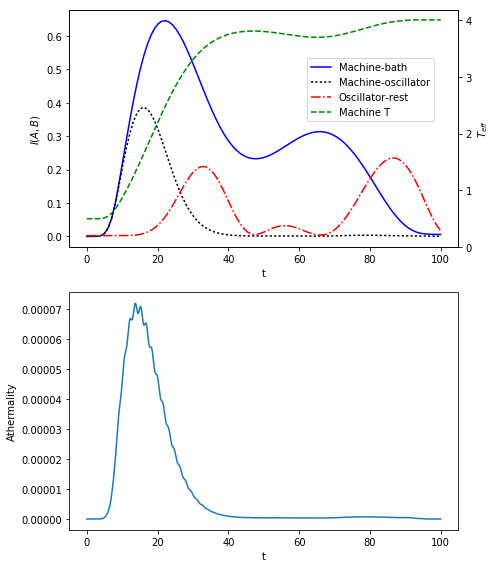

In [5]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))
tshort = np.linspace(0, tf, nt)
line1 = ax1.plot(tshort, MutInfdetbath, color='b', label='Machine-bath')
line2 = ax1.plot(tshort, MutInfdetosc, color='k', linestyle=':', label='Machine-oscillator')
line3 = ax1.plot(tshort, MutInfoscrest, color='r', linestyle='-.', label='Oscillator-rest')
ax1.set_xlabel('t')
ax1.set_ylabel('$I(A,B)$')

axtwin = ax1.twinx()
line4 = axtwin.plot(t, Teff, color='g', linestyle='--', label='Machine T')
axtwin.axes.yaxis.set_ticks([0, 1, 2, 3, 4])
axtwin.set_ylabel('$T_{eff}$')

lines = line1 + line2 + line3 + line4
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc=(0.61, 0.53))

ax2.plot(t,ath)
ax2.set_xlabel('t')
ax2.set_ylabel('Athermality')
f.tight_layout()
plt.show()